### Descrição do Case


- Empresa ABC Educacional SAC atua na educação básica e universidade (presencial, semipresencial, EAD e 100% online);
- Equipe de vendas realiza as vendas por telefone e tem uma base de cadastro de pessoas;
- Accenture irá atuar no planejamento da equipe de vendas, acreditando na priorização de pessoas com maior chance de virar cliente;

**Objetivos:**

- Qual o perfil das pessoas que tem mais chances de matricular-se?
- Quais são as pessoas mais propensas a matricular-se?

Vamos importar as bibliotecas necessárias

In [ ]:
# Importando as bibliotecas necessárias
# Utils
import numpy as np
import pandas as pd
from collections import Counter
import pickle
# Preprocessamento e Algoritmos de Cluster  - scikit-learn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
# Visualização 
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display
import matplotlib.cm as cm
import plotly.express as px

# Machine Learning Library
from catboost import Pool, CatBoostClassifier

# Formatar os gráficos em linhas após as células do notebook
%matplotlib inline

# Desativar os avisos(ex: pandas)
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_excel('Planilha em Case para Educacao.xlsx')

In [ ]:
df.head()

Propiedade           Modalidade   MODALIDADE_EAD  Id_aluno SEXO  \
0     Propio  Escola  a Distancia  SEMI-PRESENCIAL       170    M   
1     Propio  Escola  a Distancia  SEMI-PRESENCIAL       420    F   
2     Propio  Escola  a Distancia  SEMI-PRESENCIAL       761    M   
3     Propio  Escola  a Distancia  SEMI-PRESENCIAL        51    F   
4     Propio  Escola  a Distancia  SEMI-PRESENCIAL       316    M   

            NASCIMENTO                   CIDADE  UF  CANAL_VENDAS  \
0  2001-05-02 00:00:00                      JAÚ  SP        ESCOLA   
1  2001-11-21 00:00:00  CACHOEIRO DE ITAPEMIRIM  ES        ESCOLA   
2  2001-06-25 00:00:00               RIO BRANCO  AC        ESCOLA   
3  1995-11-07 00:00:00             PORTO ALEGRE  RS  ACAO EMPRESA   
4  2000-12-10 00:00:00                  ITAPEVA  SP  ACAO EMPRESA   

           CURSO DS_TURNO_INSCRICAO         DT_INSCRICAO  FL_MATRICULADO  \
0  ADMINISTRAÇÃO            NOTURNO  2020-05-21 00:00:00               0   
1  ADMINISTRAÇÃO            NOTURNO  2020-05-22 00:00:00               0   
2  ADMINISTRAÇÃO            NOTURNO  2020-05-21 00:00:00               0   
3  ADMINISTRAÇÃO            NOTURNO  2020-05-21 00:00:00               0   
4  ADMINISTRAÇÃO            NOTURNO  2020-05-21 00:00:00               0   

   VL_MENSALIDADE DS_PRIM_CANAL_VENDAS  
0            65.0               ESCOLA  
1            65.0               ESCOLA  
2            65.0               ESCOLA  
3            65.0              EMPRESA  
4            65.0              EMPRESA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Propiedade            1000 non-null   object 
 1   Modalidade            1000 non-null   object 
 2   MODALIDADE_EAD        802 non-null    object 
 3   Id_aluno              1000 non-null   int64  
 4   SEXO                  804 non-null    object 
 5   NASCIMENTO            999 non-null    object 
 6   CIDADE                939 non-null    object 
 7   UF                    997 non-null    object 
 8   CANAL_VENDAS          981 non-null    object 
 9   CURSO                 990 non-null    object 
 10  DS_TURNO_INSCRICAO    993 non-null    object 
 11  DT_INSCRICAO          990 non-null    object 
 12  FL_MATRICULADO        1000 non-null   int64  
 13  VL_MENSALIDADE        963 non-null    float64
 14  DS_PRIM_CANAL_VENDAS  978 non-null    object 
dtypes: float64(1), int64(2

In [ ]:
df.describe()

Id_aluno  FL_MATRICULADO  VL_MENSALIDADE
count  1000.000000      1000.00000      963.000000
mean    500.500000         0.04600       84.364528
std     288.819436         0.20959       23.092244
min       1.000000         0.00000        0.000000
25%     250.750000         0.00000       65.000000
50%     500.500000         0.00000       65.000000
75%     750.250000         0.00000      110.000000
max    1000.000000         1.00000      110.000000

In [ ]:
df.isnull().sum()

Propiedade                0
Modalidade                0
MODALIDADE_EAD          198
Id_aluno                  0
SEXO                    196
NASCIMENTO                1
CIDADE                   61
UF                        3
CANAL_VENDAS             19
CURSO                    10
DS_TURNO_INSCRICAO        7
DT_INSCRICAO             10
FL_MATRICULADO            0
VL_MENSALIDADE           37
DS_PRIM_CANAL_VENDAS     22
dtype: int64

In [ ]:
df.keys()

Index(['Propiedade', 'Modalidade', 'MODALIDADE_EAD', 'Id_aluno', 'SEXO',
       'NASCIMENTO', 'CIDADE', 'UF', 'CANAL_VENDAS', 'CURSO',
       'DS_TURNO_INSCRICAO', 'DT_INSCRICAO', 'FL_MATRICULADO',
       'VL_MENSALIDADE', 'DS_PRIM_CANAL_VENDAS'],
      dtype='object')

## Pré-processamento dos dados

De uma forma geral, vamos primeiro analisar os dados faltantes em cada variável

#### 1- Dados Ausentes

<AxesSubplot:>

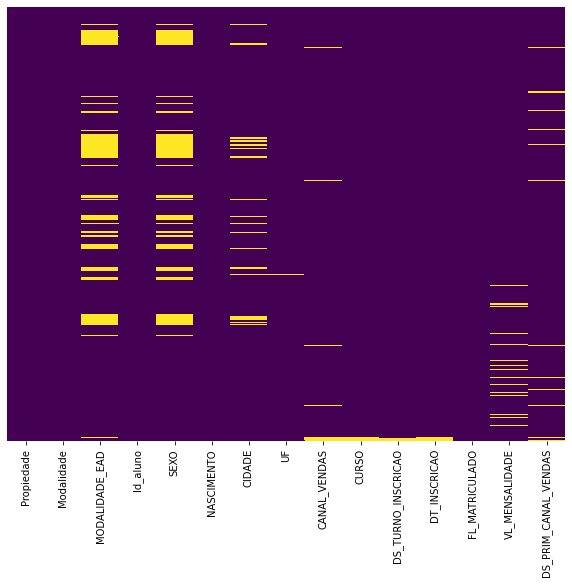

In [ ]:
plt.figure(figsize=(10,8)) 
sns.heatmap(df.isnull()
            ,yticklabels=False,cbar=False,cmap='viridis')

Vamos unir as duas colunas por apresentar informações só de modalidades de cursos.

In [ ]:
df['Modalidade'].value_counts()

Escola  a Distancia    802
Presencial             198
Name: Modalidade, dtype: int64

In [ ]:
df['MODALIDADE_EAD'].value_counts()

SEMI-PRESENCIAL    386
100% ONLINE        230
EAD PREMIUM        186
Name: MODALIDADE_EAD, dtype: int64

In [ ]:
df_modalidades = df[['Modalidade','MODALIDADE_EAD']]

In [ ]:
df_modalidades.head(44)

Modalidade   MODALIDADE_EAD
0   Escola  a Distancia  SEMI-PRESENCIAL
1   Escola  a Distancia  SEMI-PRESENCIAL
2   Escola  a Distancia  SEMI-PRESENCIAL
3   Escola  a Distancia  SEMI-PRESENCIAL
4   Escola  a Distancia  SEMI-PRESENCIAL
5   Escola  a Distancia  SEMI-PRESENCIAL
6   Escola  a Distancia  SEMI-PRESENCIAL
7   Escola  a Distancia  SEMI-PRESENCIAL
8   Escola  a Distancia  SEMI-PRESENCIAL
9   Escola  a Distancia  SEMI-PRESENCIAL
10  Escola  a Distancia  SEMI-PRESENCIAL
11  Escola  a Distancia  SEMI-PRESENCIAL
12  Escola  a Distancia      100% ONLINE
13  Escola  a Distancia  SEMI-PRESENCIAL
14  Escola  a Distancia  SEMI-PRESENCIAL
15  Escola  a Distancia  SEMI-PRESENCIAL
16  Escola  a Distancia  SEMI-PRESENCIAL
17  Escola  a Distancia      100% ONLINE
18  Escola  a Distancia  SEMI-PRESENCIAL
19  Escola  a Distancia  SEMI-PRESENCIAL
20  Escola  a Distancia  SEMI-PRESENCIAL
21  Escola  a Distancia  SEMI-PRESENCIAL
22  Escola  a Distancia  SEMI-PRESENCIAL
23  Escola  a Distancia  SEMI-PRESENCIAL
24  Escola  a Distancia      100% ONLINE
25  Escola  a Distancia  SEMI-PRESENCIAL
26  Escola  a Distancia      100% ONLINE
27  Escola  a Distancia  SEMI-PRESENCIAL
28  Escola  a Distancia      100% ONLINE
29  Escola  a Distancia      100% ONLINE
30  Escola  a Distancia      100% ONLINE
31  Escola  a Distancia  SEMI-PRESENCIAL
32  Escola  a Distancia  SEMI-PRESENCIAL
33  Escola  a Distancia  SEMI-PRESENCIAL
34  Escola  a Distancia      100% ONLINE
35  Escola  a Distancia      100% ONLINE
36  Escola  a Distancia      100% ONLINE
37  Escola  a Distancia      100% ONLINE
38  Escola  a Distancia      100% ONLINE
39  Escola  a Distancia  SEMI-PRESENCIAL
40  Escola  a Distancia      100% ONLINE
41  Escola  a Distancia      100% ONLINE
42           Presencial              NaN
43  Escola  a Distancia      100% ONLINE

Vamos criar uma variável modalidade com todas as modalidades em só uma coluna, adicionando nos valores NaN da variável MODALIDADE_EAD o registro presencial.

Obs: foi observado previamente que onde faltava registro na coluna MODALIDADE_EAD era justamente a mesma posição que apresentava o registro presencial na coluna Modalidade. Portanto, uni-las não mudaria em nada da estrutura do BD final.

In [ ]:
df['MODALIDADE_EAD'].fillna(value='Presencial', inplace = True) 

In [ ]:
df['MODALIDADE_EAD'].value_counts()

SEMI-PRESENCIAL    386
100% ONLINE        230
Presencial         198
EAD PREMIUM        186
Name: MODALIDADE_EAD, dtype: int64

In [ ]:
df ['MODALIDADES'] = df['MODALIDADE_EAD']

In [ ]:
df.head()

Propiedade           Modalidade   MODALIDADE_EAD  Id_aluno SEXO  \
0     Propio  Escola  a Distancia  SEMI-PRESENCIAL       170    M   
1     Propio  Escola  a Distancia  SEMI-PRESENCIAL       420    F   
2     Propio  Escola  a Distancia  SEMI-PRESENCIAL       761    M   
3     Propio  Escola  a Distancia  SEMI-PRESENCIAL        51    F   
4     Propio  Escola  a Distancia  SEMI-PRESENCIAL       316    M   

            NASCIMENTO                   CIDADE  UF  CANAL_VENDAS  \
0  2001-05-02 00:00:00                      JAÚ  SP        ESCOLA   
1  2001-11-21 00:00:00  CACHOEIRO DE ITAPEMIRIM  ES        ESCOLA   
2  2001-06-25 00:00:00               RIO BRANCO  AC        ESCOLA   
3  1995-11-07 00:00:00             PORTO ALEGRE  RS  ACAO EMPRESA   
4  2000-12-10 00:00:00                  ITAPEVA  SP  ACAO EMPRESA   

           CURSO DS_TURNO_INSCRICAO         DT_INSCRICAO  FL_MATRICULADO  \
0  ADMINISTRAÇÃO            NOTURNO  2020-05-21 00:00:00               0   
1  ADMINISTRAÇÃO            NOTURNO  2020-05-22 00:00:00               0   
2  ADMINISTRAÇÃO            NOTURNO  2020-05-21 00:00:00               0   
3  ADMINISTRAÇÃO            NOTURNO  2020-05-21 00:00:00               0   
4  ADMINISTRAÇÃO            NOTURNO  2020-05-21 00:00:00               0   

   VL_MENSALIDADE DS_PRIM_CANAL_VENDAS      MODALIDADES  
0            65.0               ESCOLA  SEMI-PRESENCIAL  
1            65.0               ESCOLA  SEMI-PRESENCIAL  
2            65.0               ESCOLA  SEMI-PRESENCIAL  
3            65.0              EMPRESA  SEMI-PRESENCIAL  
4            65.0              EMPRESA  SEMI-PRESENCIAL

In [ ]:
df['SEXO'].isna().mean() #PORCENTAGEM DE DADOS FALTANTES EM 'SEXO'

0.196

As colunas Propriedade, Modalidade (antiga), MODALIDADE_EAD (antiga), Id_aluno, Data de matrícula foram excluidas por não serem úteis. A coluna sexo também foi excluida pois apresenta muitos dados faltantes (CERCA DE 20%).

In [ ]:
#excluindo as variáveis 'Modalidade(antiga), MODALIDADE_EAD,Id_aluno, sexo e Data de matrícula  '
del df ['Modalidade']
del df ['MODALIDADE_EAD']
del df ['SEXO']
del df ['Id_aluno']
del df ['Propiedade']
del df ['DT_INSCRICAO']

In [ ]:
df.head()

NASCIMENTO                   CIDADE  UF  CANAL_VENDAS  \
0  2001-05-02 00:00:00                      JAÚ  SP        ESCOLA   
1  2001-11-21 00:00:00  CACHOEIRO DE ITAPEMIRIM  ES        ESCOLA   
2  2001-06-25 00:00:00               RIO BRANCO  AC        ESCOLA   
3  1995-11-07 00:00:00             PORTO ALEGRE  RS  ACAO EMPRESA   
4  2000-12-10 00:00:00                  ITAPEVA  SP  ACAO EMPRESA   

           CURSO DS_TURNO_INSCRICAO  FL_MATRICULADO  VL_MENSALIDADE  \
0  ADMINISTRAÇÃO            NOTURNO               0            65.0   
1  ADMINISTRAÇÃO            NOTURNO               0            65.0   
2  ADMINISTRAÇÃO            NOTURNO               0            65.0   
3  ADMINISTRAÇÃO            NOTURNO               0            65.0   
4  ADMINISTRAÇÃO            NOTURNO               0            65.0   

  DS_PRIM_CANAL_VENDAS      MODALIDADES  
0               ESCOLA  SEMI-PRESENCIAL  
1               ESCOLA  SEMI-PRESENCIAL  
2               ESCOLA  SEMI-PRESENCIAL  
3              EMPRESA  SEMI-PRESENCIAL  
4              EMPRESA  SEMI-PRESENCIAL

<AxesSubplot:>

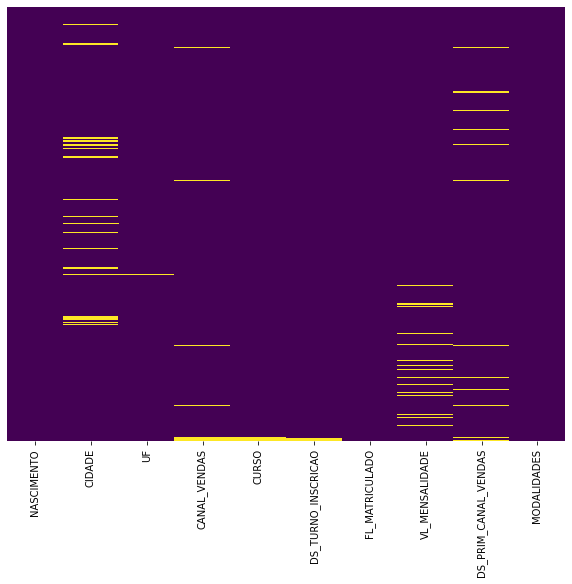

In [ ]:
plt.figure(figsize=(10,8)) 
sns.heatmap(df.isnull()
            ,yticklabels=False,cbar=False,cmap='viridis')

As variáveis ainda apresentam dados faltantes, vamos adicionar cada um conforme descriçaõ abaixo:

- CIDADE: Cada cidade com dado faltante será substituida pela capital da UF a que pertence;

- MENSALIDADE, UF, CANAL DE VENDAS, CURSO, TURNO DATA DA INSCRIÇÃO e DS_PRIM_CANAL_VENDAS: subtituir pela mediana.

- normalização de maiusculas e minusculas 

In [ ]:
df['CIDADE'].isnull().sum()

61

In [ ]:
df['CIDADE'].fillna(value= 'sub', inplace = True)

In [ ]:
# df = df.query('CIDADE =="sub" & UF == "RJ"')

In [ ]:
df

NASCIMENTO                   CIDADE  UF  CANAL_VENDAS  \
0    2001-05-02 00:00:00                      JAÚ  SP        ESCOLA   
1    2001-11-21 00:00:00  CACHOEIRO DE ITAPEMIRIM  ES        ESCOLA   
2    2001-06-25 00:00:00               RIO BRANCO  AC        ESCOLA   
3    1995-11-07 00:00:00             PORTO ALEGRE  RS  ACAO EMPRESA   
4    2000-12-10 00:00:00                  ITAPEVA  SP  ACAO EMPRESA   
..                   ...                      ...  ..           ...   
995  1982-04-01 00:00:00         PARAÍSO DO NORTE  PR           NaN   
996  1993-12-25 00:00:00                SÃO PAULO  SP           NaN   
997  1998-02-10 00:00:00                 TREMEMBÉ  SP           NaN   
998  1997-09-29 00:00:00                GOIANORTE  TO           NaN   
999  1998-04-03 00:00:00                  TAUBATÉ  SP           NaN   

             CURSO DS_TURNO_INSCRICAO  FL_MATRICULADO  VL_MENSALIDADE  \
0    ADMINISTRAÇÃO            NOTURNO               0            65.0   
1    ADMINISTRAÇÃO            NOTURNO               0            65.0   
2    ADMINISTRAÇÃO            NOTURNO               0            65.0   
3    ADMINISTRAÇÃO            NOTURNO               0            65.0   
4    ADMINISTRAÇÃO            NOTURNO               0            65.0   
..             ...                ...             ...             ...   
995            NaN                NaN               0            65.0   
996            NaN                NaN               0            65.0   
997            NaN                NaN               0            65.0   
998            NaN                NaN               0            65.0   
999            NaN                NaN               0           110.0   

    DS_PRIM_CANAL_VENDAS      MODALIDADES  
0                 ESCOLA  SEMI-PRESENCIAL  
1                 ESCOLA  SEMI-PRESENCIAL  
2                 ESCOLA  SEMI-PRESENCIAL  
3                EMPRESA  SEMI-PRESENCIAL  
4                EMPRESA  SEMI-PRESENCIAL  
..                   ...              ...  
995          CALL CENTER  SEMI-PRESENCIAL  
996          CALL CENTER      100% ONLINE  
997             INTERNET  SEMI-PRESENCIAL  
998                  NaN      100% ONLINE  
999                  NaN      100% ONLINE  

[1000 rows x 10 columns]

In [ ]:
if (df['UF']=="RJ").any: 
    df.CIDADE.replace(to_replace=dict(sub= 'RIO DE JANEIRO'), inplace=True) 
    
if (df['UF']=="SP").any: 
    df.CIDADE.replace(to_replace=dict(sub= 'SÃO PAULO'), inplace=True) 

if (df['UF']=="MG").any: 
    df.CIDADE.replace(to_replace=dict(sub= 'BELO HORIZONTE'), inplace=True) 
    
if (df['UF']=="GO").any: 
    df.CIDADE.replace(to_replace=dict(sub= 'GOIÂNIA'), inplace=True) 

In [ ]:
df.count()

NASCIMENTO               999
CIDADE                  1000
UF                       997
CANAL_VENDAS             981
CURSO                    990
DS_TURNO_INSCRICAO       993
FL_MATRICULADO          1000
VL_MENSALIDADE           963
DS_PRIM_CANAL_VENDAS     978
MODALIDADES             1000
dtype: int64

In [ ]:
df.head(50)

NASCIMENTO                   CIDADE  UF         CANAL_VENDAS  \
0   2001-05-02 00:00:00                      JAÚ  SP               ESCOLA   
1   2001-11-21 00:00:00  CACHOEIRO DE ITAPEMIRIM  ES               ESCOLA   
2   2001-06-25 00:00:00               RIO BRANCO  AC               ESCOLA   
3   1995-11-07 00:00:00             PORTO ALEGRE  RS         ACAO EMPRESA   
4   2000-12-10 00:00:00                  ITAPEVA  SP         ACAO EMPRESA   
5   1999-06-05 00:00:00                 VALINHOS  SP         ACAO EMPRESA   
6   2002-07-29 00:00:00                 ALVORADA  RS                 ENEM   
7   2000-01-02 00:00:00  JABOATÃO DOS GUARARAPES  PE                 ENEM   
8   2001-03-15 00:00:00                 ALVORADA  RS                 ENEM   
9   1996-01-01 00:00:00  CACHOEIRO DE ITAPEMIRIM  ES                 ENEM   
10  2000-06-09 00:00:00  CACHOEIRO DE ITAPEMIRIM  ES                 ENEM   
11  1990-06-13 00:00:00                 CASCAVEL  PR                 ENEM   
12  1996-04-11 00:00:00                NOVA LIMA  MG                 ENEM   
13  1901-01-01 00:00:00                  MOSSORÓ  RN                 ENEM   
14  2000-12-22 00:00:00           BARRA DO CHOÇA  BA                 ENEM   
15  1996-02-17 00:00:00       RIBEIRÃO DAS NEVES  MG                 ENEM   
16  1999-03-11 00:00:00                 ALVORADA  RS                 ENEM   
17  2000-01-14 00:00:00                 ALVORADA  RS                 ENEM   
18  1984-03-04 00:00:00                 CAMAÇARI  BA                 ENEM   
19  2001-02-03 00:00:00             POUSO ALEGRE  MG                GUERR   
20  1985-10-04 00:00:00                 SALVADOR  BA                GUERR   
21  2001-10-08 00:00:00           RIO DE JANEIRO  RJ          CALL CENTER   
22  1998-07-26 00:00:00           RIO DE JANEIRO  RJ          CALL CENTER   
23  2000-06-15 00:00:00           RIO DE JANEIRO  RJ          CALL CENTER   
24  2000-03-25 00:00:00           RIO DE JANEIRO  RJ          CALL CENTER   
25  1999-05-08 00:00:00           RIO DE JANEIRO  RJ          CALL CENTER   
26  1995-05-18 00:00:00           RIO DE JANEIRO  RJ          CALL CENTER   
27  1998-01-15 00:00:00                SÃO PAULO  SP          CALL CENTER   
28  1992-03-28 00:00:00              SANTO ANDRÉ  SP          CALL CENTER   
29  1994-02-10 00:00:00          TABOÃO DA SERRA  SP          CALL CENTER   
30  2000-04-04 00:00:00           RIO DE JANEIRO  RJ          CALL CENTER   
31  2001-05-04 00:00:00           RIO DE JANEIRO  RJ          CALL CENTER   
32  1994-05-09 00:00:00           RIO DE JANEIRO  RJ          CALL CENTER   
33  1999-02-19 00:00:00           RIO DE JANEIRO  RJ          CALL CENTER   
34  1991-12-12 00:00:00           RIO DE JANEIRO  RJ          CALL CENTER   
35  1996-03-10 00:00:00           RIO DE JANEIRO  RJ          CALL CENTER   
36  2002-07-01 00:00:00           RIO DE JANEIRO  RJ          CALL CENTER   
37  1985-01-19 00:00:00                  GOIÂNIA  GO          CALL CENTER   
38  1991-01-21 00:00:00           RIO DE JANEIRO  RJ          CALL CENTER   
39  1991-10-11 00:00:00           RIO DE JANEIRO  RJ          CALL CENTER   
40  1996-08-24 00:00:00      COCALZINHO DE GOIÁS  GO          CALL CENTER   
41  1998-05-10 00:00:00                  JUNDIAÍ  SP             INTERNET   
42  1997-08-20 00:00:00           RIO DE JANEIRO  SP          CALL CENTER   
43  1997-05-01 00:00:00                   CUIABÁ  MT          CALL CENTER   
44  1999-11-11 00:00:00                    BELÉM  PA            CONSULTOR   
45  1995-06-17 00:00:00                 SALVADOR  BA           EDUCA MAIS   
46  2000-09-22 00:00:00                 BRASÍLIA  DF  GIRO DAS PROFISSOES   
47  2002-04-15 00:00:00                SÃO PAULO  SP             INTERNET   
48  1989-11-16 00:00:00      SÃO JOSÉ DOS CAMPOS  SP             INTERNET   
49  1981-02-28 00:00:00                SÃO PAULO  SP             INTERNET   

            CURSO DS_TURNO_INSCRICAO  FL_MATRICULADO  VL_MENSALIDADE  \
0   ADMINISTR

<AxesSubplot:>

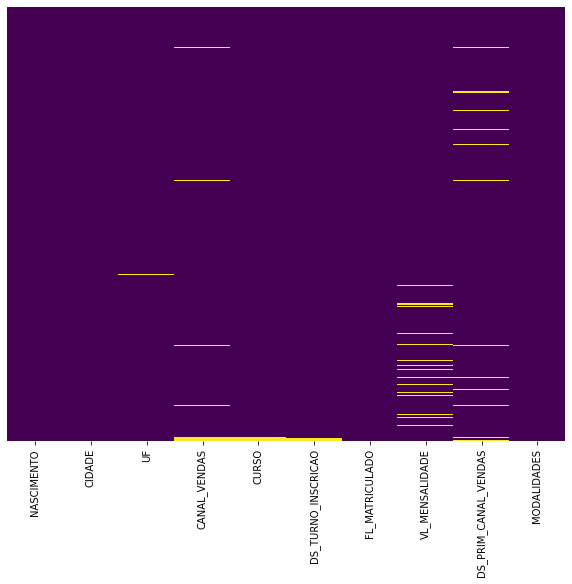

In [ ]:
plt.figure(figsize=(10,8)) 
sns.heatmap(df.isnull()
            ,yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
df.keys()

Index(['NASCIMENTO', 'CIDADE', 'UF', 'CANAL_VENDAS', 'CURSO',
       'DS_TURNO_INSCRICAO', 'FL_MATRICULADO', 'VL_MENSALIDADE',
       'DS_PRIM_CANAL_VENDAS', 'MODALIDADES'],
      dtype='object')

In [ ]:
df['UF'].isnull().sum()

3

In [ ]:
df['UF'].value_counts().head(10) # RJ é o estado que mais apresenta dados na variável 'UF'. Vamos substituir os dados faltantes por RJ

RJ    220
SP    194
MG     90
BA     75
RS     43
PA     38
SC     36
GO     30
MA     29
CE     28
Name: UF, dtype: int64

In [ ]:
df['UF'].fillna(value='RJ', inplace = True)

In [ ]:
df['UF'].isnull().sum()

0

In [ ]:
df['CANAL_VENDAS'].isnull().sum()

19

In [ ]:
df['CANAL_VENDAS'].value_counts().head(10) #internet é o registro mais comum nessa coluna

INTERNET         329
CALL CENTER      194
LIVES             82
ENEM              76
GUERR             72
ESCOLA            39
OUTRAS            33
OUTDOOR           31
CONSULTOR         28
REDES SOCIAIS     27
Name: CANAL_VENDAS, dtype: int64

In [ ]:
df['CANAL_VENDAS'].fillna(value='INTERNET', inplace = True)

In [ ]:
df['CANAL_VENDAS'].isnull().sum()

0

In [ ]:
df['CURSO'].isnull().sum()

10

In [ ]:
df['CURSO'].value_counts().head(10) #Adm é o registro mais comum nessa coluna

ADMINISTRAÇÃO                                                      199
PEDAGOGIA - LICENCIATURA                                            79
ENFERMAGEM                                                          65
SUPERIOR DE TECNOLOGIA EM GESTÃO DE RECURSOS HUMANOS                40
SUPERIOR DE TECNOLOGIA EM ANÁLISE E DESENVOLVIMENTO DE SISTEMAS     40
EDUCAÇÃO FÍSICA - LICENCIATURA                                      34
CIÊNCIAS CONTÁBEIS                                                  30
Direito - N                                                         29
SERVIÇO SOCIAL                                                      22
SUPERIOR DE TECNOLOGIA EM GESTÃO HOSPITALAR                         19
Name: CURSO, dtype: int64

In [ ]:
df['CURSO'].fillna(value='ADMINISTRAÇÃO', inplace = True)

In [ ]:
df['CURSO'].isnull().sum()

0

In [ ]:
df['DS_TURNO_INSCRICAO'].isnull().sum()

7

In [ ]:
df['DS_TURNO_INSCRICAO'].value_counts().head(10) #Noturno é o registro mais comum nessa coluna

NOTURNO       714
Noturno       158
MATUTINO       81
Matutino       37
Vespertino      3
Name: DS_TURNO_INSCRICAO, dtype: int64

In [ ]:
df['DS_TURNO_INSCRICAO'].fillna(value='Noturno', inplace = True)

In [ ]:
df['DS_TURNO_INSCRICAO'].isnull().sum()

0

In [ ]:
# a coluna DS_TURNO_INSCRICAO apresenta registros iguais em maiusculo e minusculo, vamos ajustar:

df['DS_TURNO_INSCRICAO']= df['DS_TURNO_INSCRICAO'].apply(lambda x: 'Noturno' if x=='NOTURNO' else x)
df['DS_TURNO_INSCRICAO']= df['DS_TURNO_INSCRICAO'].apply(lambda x: 'Matutino' if x=='MATUTINO' else x)
df['DS_TURNO_INSCRICAO'].value_counts()

Noturno       879
Matutino      118
Vespertino      3
Name: DS_TURNO_INSCRICAO, dtype: int64

In [ ]:
df['VL_MENSALIDADE'].isnull().sum()

37

In [ ]:
df['VL_MENSALIDADE'].value_counts().head(10) #65.00 é o registro mais comum nessa coluna

65.00     535
110.00    421
0.00        5
73.75       1
84.29       1
Name: VL_MENSALIDADE, dtype: int64

In [ ]:
df['VL_MENSALIDADE'].fillna(value='65.00', inplace = True)

In [ ]:
df['VL_MENSALIDADE'].isnull().sum()

0

In [ ]:
df['DS_PRIM_CANAL_VENDAS'].isnull().sum()

22

In [ ]:
df['DS_PRIM_CANAL_VENDAS'].value_counts().head(10) #INTERNET é o registro mais comum nessa coluna

INTERNET         322
CALL CENTER      273
ENEM              77
LIVES             73
ESCOLA            40
OUTRAS            36
OUTDOOR           32
CONSULTOR         31
INDICACAO         27
REDES SOCIAIS     23
Name: DS_PRIM_CANAL_VENDAS, dtype: int64

In [ ]:
df['DS_PRIM_CANAL_VENDAS'].fillna(value='INTERNET', inplace = True)

In [ ]:
df['DS_PRIM_CANAL_VENDAS'].isnull().sum()

0

<AxesSubplot:>

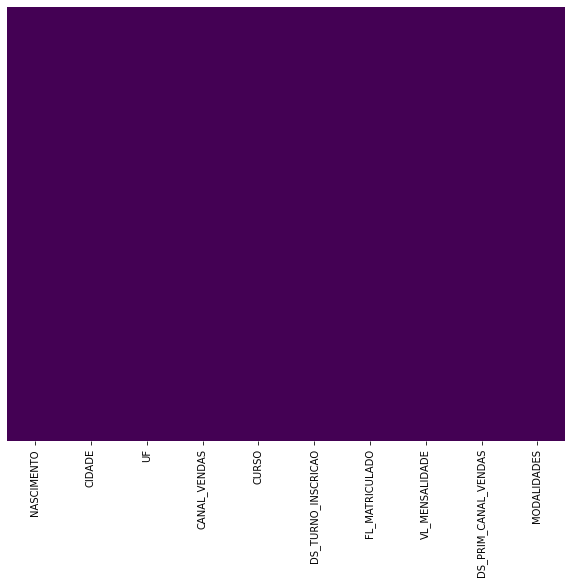

In [ ]:
plt.figure(figsize=(10,8)) 
sns.heatmap(df.isnull()
            ,yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
df['CIDADE'].value_counts().head(10)

RIO DE JANEIRO    199
Sao Paulo          73
SÃO PAULO          40
BRASÍLIA           14
São Paulo          14
Rio de Janeiro     10
Itagibá             9
FORTALEZA           8
BELÉM               7
SALVADOR            7
Name: CIDADE, dtype: int64

In [ ]:
# a coluna CIDADE apresenta registros iguais em maiusculo e minusculo, vamos ajustar:

df['CIDADE']= df['CIDADE'].apply(lambda x: 'RIO DE JANEIRO' if x=='Rio de Janeiro' else x)
df['CIDADE']= df['CIDADE'].apply(lambda x: 'SÃO PAULO' if x=='Sao Paulo' else x)
df['CIDADE']= df['CIDADE'].apply(lambda x: 'SÃO PAULO' if x=='São Paulo' else x)

In [ ]:
df['CIDADE'].value_counts().head(10)

RIO DE JANEIRO        209
SÃO PAULO             127
BRASÍLIA               14
Itagibá                 9
FORTALEZA               8
CARUARU                 7
BELO HORIZONTE          7
JOINVILLE               7
ITABIRA                 7
SÃO JOÃO DE MERITI      7
Name: CIDADE, dtype: int64

In [ ]:
df.isnull().sum()

NASCIMENTO              1
CIDADE                  0
UF                      0
CANAL_VENDAS            0
CURSO                   0
DS_TURNO_INSCRICAO      0
FL_MATRICULADO          0
VL_MENSALIDADE          0
DS_PRIM_CANAL_VENDAS    0
MODALIDADES             0
dtype: int64

In [ ]:
df['NASCIMENTO'].value_counts().head(10) #2000-01-01 00:00:00 é o registro mais comum nessa coluna

2000-01-01 00:00:00    28
1990-01-01 00:00:00     7
2000-10-10 00:00:00     5
1999-01-01 00:00:00     5
0002-11-30 00:00:00     4
2000-02-02 00:00:00     4
1991-01-01 00:00:00     3
1999-10-10 00:00:00     3
1991-12-12 00:00:00     3
1990-10-10 00:00:00     3
Name: NASCIMENTO, dtype: int64

In [ ]:
df['NASCIMENTO'].fillna(value='2000-01-01 00:00:00', inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   NASCIMENTO            1000 non-null   object
 1   CIDADE                1000 non-null   object
 2   UF                    1000 non-null   object
 3   CANAL_VENDAS          1000 non-null   object
 4   CURSO                 1000 non-null   object
 5   DS_TURNO_INSCRICAO    1000 non-null   object
 6   FL_MATRICULADO        1000 non-null   int64 
 7   VL_MENSALIDADE        1000 non-null   object
 8   DS_PRIM_CANAL_VENDAS  1000 non-null   object
 9   MODALIDADES           1000 non-null   object
dtypes: int64(1), object(9)
memory usage: 78.2+ KB


#### 2- Transformação de datas

In [ ]:
#vamos transformar alguns atributos 

#data de nascimento em idade

df['NASCIMENTO'] = df['NASCIMENTO'].astype(str)

In [ ]:
#2001-05-02 00:00:00
df['DATA'] = df['NASCIMENTO'].apply(lambda nascimento: nascimento.split(' ')[0])

In [ ]:
df['DATA']

0      2001-05-02
1      2001-11-21
2      2001-06-25
3      1995-11-07
4      2000-12-10
          ...    
995    1982-04-01
996    1993-12-25
997    1998-02-10
998    1997-09-29
999    1998-04-03
Name: DATA, Length: 1000, dtype: object

In [ ]:
df['DATA'] = pd.to_datetime(df['DATA'], errors = 'coerce')

In [ ]:
df['DATA']

0     2001-05-02
1     2001-11-21
2     2001-06-25
3     1995-11-07
4     2000-12-10
         ...    
995   1982-04-01
996   1993-12-25
997   1998-02-10
998   1997-09-29
999   1998-04-03
Name: DATA, Length: 1000, dtype: datetime64[ns]

In [ ]:
date = df['DATA']

In [ ]:
df["IDADE"] = pd.to_datetime("now") - date

In [ ]:
df["IDADE"]

0      7262 days 23:26:22.087291
1      7059 days 23:26:22.087291
2      7208 days 23:26:22.087291
3      9265 days 23:26:22.087291
4      7405 days 23:26:22.087291
                 ...            
995   14233 days 23:26:22.087291
996    9947 days 23:26:22.087291
997    8439 days 23:26:22.087291
998    8573 days 23:26:22.087291
999    8387 days 23:26:22.087291
Name: IDADE, Length: 1000, dtype: timedelta64[ns]

In [ ]:
df["IDADE"] = df["IDADE"] /  np.timedelta64(1, "Y") #(convertê-lo em um timedelta com uma precisão de ano)

In [ ]:
df["IDADE"]

0      19.885355
1      19.329560
2      19.737508
3      25.369382
4      20.276875
         ...    
995    38.971304
996    27.236635
997    23.107871
998    23.474751
999    22.965500
Name: IDADE, Length: 1000, dtype: float64

In [ ]:
df["IDADE"].isnull().sum()

8

In [ ]:
df['IDADE'].value_counts().head(10) #21.217778 é o registro mais comum nessa coluna

21.218715    29
31.217552     7
22.218051     5
20.443888     5
21.131102     4
27.488522     3
21.870337     3
30.218216     3
21.445962     3
30.445462     3
Name: IDADE, dtype: int64

In [ ]:
df['IDADE'].fillna(value='21.217778', inplace = True)

In [ ]:
df["IDADE"].isnull().sum()

0

In [ ]:
#VAMOS FICAR SOMENTE COM A COLUNA IDADE E EXCLUIR AS ANTIGAS

del df ['NASCIMENTO']
del df ['DATA']

In [ ]:
df.info()
# Salvando em Arquivo XLSX
#df.to_excel('df_str.xlsx', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CIDADE                1000 non-null   object
 1   UF                    1000 non-null   object
 2   CANAL_VENDAS          1000 non-null   object
 3   CURSO                 1000 non-null   object
 4   DS_TURNO_INSCRICAO    1000 non-null   object
 5   FL_MATRICULADO        1000 non-null   int64 
 6   VL_MENSALIDADE        1000 non-null   object
 7   DS_PRIM_CANAL_VENDAS  1000 non-null   object
 8   MODALIDADES           1000 non-null   object
 9   IDADE                 1000 non-null   object
dtypes: int64(1), object(9)
memory usage: 78.2+ KB


#### 3- Transformação de atributos categóricos em numéricos

As colunas que apresentam registros categóricos são:
'CIDADE', 'UF', 'CANAL_VENDAS', 'CURSO','DS_TURNO_INSCRICAO', 'DS_PRIM_CANAL_VENDAS', 'MODALIDADES'. Precisamos transformar esses atributos em números.

In [ ]:
#importando biblioteca do scikit-learning

from sklearn.preprocessing import LabelEncoder

In [ ]:
labelenconder = LabelEncoder()

In [ ]:
#TRANSFORMANDO EM NUMÉRICO
df['CIDADE'] = labelenconder.fit_transform(df['CIDADE'])
df['UF'] = labelenconder.fit_transform(df['UF'])
df['CANAL_VENDAS'] = labelenconder.fit_transform(df['CANAL_VENDAS'])
df['CURSO'] = labelenconder.fit_transform(df['CURSO'])
df['DS_TURNO_INSCRICAO'] = labelenconder.fit_transform(df['DS_TURNO_INSCRICAO'])
df['DS_PRIM_CANAL_VENDAS'] = labelenconder.fit_transform(df['DS_PRIM_CANAL_VENDAS'])
df['MODALIDADES'] = labelenconder.fit_transform(df['MODALIDADES'])

#VALOR DA MENSALIDADE E IDADE ESTÃO COMO 'STRING' MAS SÃO NÚMEROS
df['VL_MENSALIDADE'] = pd.to_numeric(df['VL_MENSALIDADE'])
df['IDADE'] = pd.to_numeric(df['IDADE'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CIDADE                1000 non-null   int32  
 1   UF                    1000 non-null   int32  
 2   CANAL_VENDAS          1000 non-null   int32  
 3   CURSO                 1000 non-null   int32  
 4   DS_TURNO_INSCRICAO    1000 non-null   int32  
 5   FL_MATRICULADO        1000 non-null   int64  
 6   VL_MENSALIDADE        1000 non-null   float64
 7   DS_PRIM_CANAL_VENDAS  1000 non-null   int32  
 8   MODALIDADES           1000 non-null   int32  
 9   IDADE                 1000 non-null   float64
dtypes: float64(2), int32(7), int64(1)
memory usage: 50.9 KB


In [ ]:
df.head(20)

CIDADE  UF  CANAL_VENDAS  CURSO  DS_TURNO_INSCRICAO  FL_MATRICULADO  \
0      183  26             7      0                   1               0   
1       61   8             7      0                   1               0   
2      286   0             7      0                   1               0   
3      272  23             0      0                   1               0   
4      163  26             0      0                   1               0   
5      374  26             0      0                   1               0   
6        9  23             6      0                   1               0   
7      173  16             6      0                   1               0   
8        9  23             6      0                   1               0   
9       61   8             6      0                   1               0   
10      61   8             6      0                   1               0   
11      83  18             6      0                   1               0   
12     236  11             6      0                   1               0   
13     225  20             6      0                   1               0   
14      38   4             6      0                   1               0   
15     282  11             6      0                   1               0   
16       9  23             6      0                   1               0   
17       9  23             6      0                   1               0   
18      64   4             6      0                   1               0   
19     275  11            10      0                   1               0   

    VL_MENSALIDADE  DS_PRIM_CANAL_VENDAS  MODALIDADES       IDADE  
0             65.0                     6            3   19.885355  
1             65.0                     6            3   19.329560  
2             65.0                     6            3   19.737508  
3             65.0                     4            3   25.369382  
4             65.0                     4            3   20.276875  
5             65.0                     4            3   21.793676  
6             65.0                     5            3   18.645083  
7             65.0                     5            3   21.215977  
8             65.0                     5            3   20.016774  
9             65.0                     5            3   25.218797  
10            65.0                     5            3   20.780650  
11            65.0                     5            3   30.771273  
12            65.0                     5            0   24.942269  
13            65.0                     5            3  120.218695  
14            65.0                     5            3   20.244020  
15            65.0                     5            3   25.090116  
16            65.0                     5            3   22.029136  
17            65.0                     5            0   21.183123  
18            65.0                     5            3   37.046556  
19            65.0                     0            3   20.126290

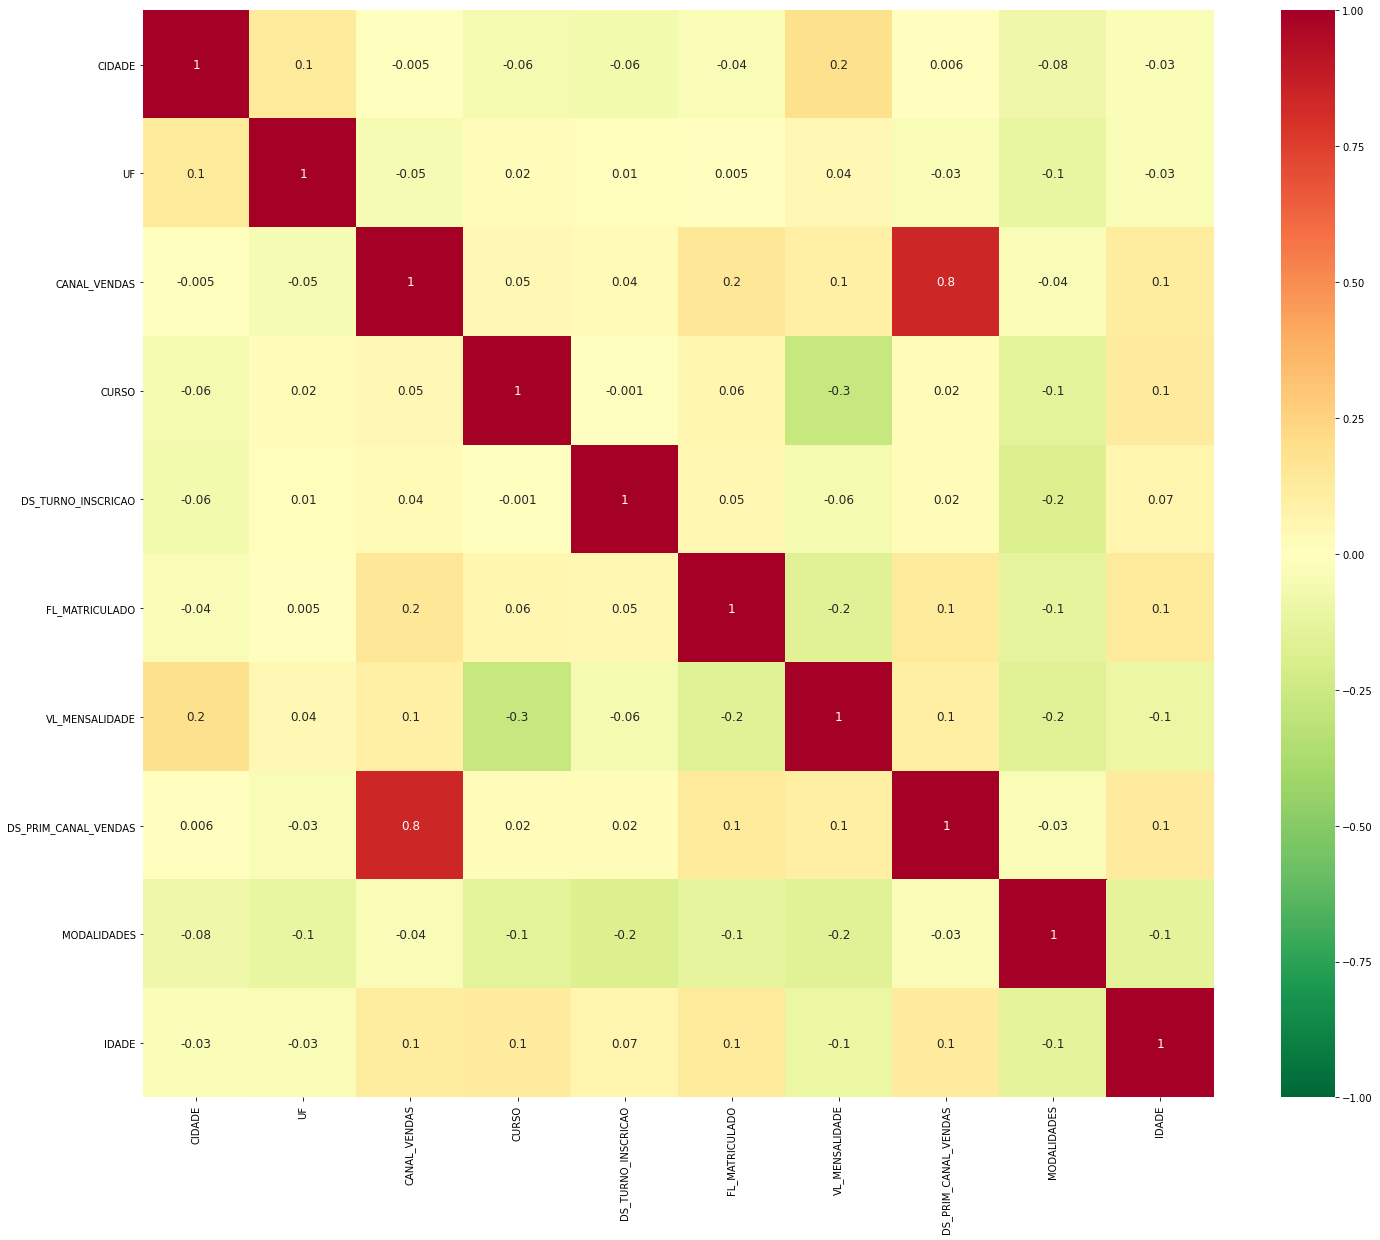

In [ ]:
# Matriz de correlação das variáveis numéricas
corrmat = df.corr()
ax = plt.subplots(figsize=(24, 20))
sns.heatmap(corrmat, annot=True, annot_kws={"size": 12}, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'RdYlGn_r');

In [ ]:
#Existe uma forte correlação entre CANAL_VENDAS e DS_PRIM_CANAL_VENDAS, portanto vamos excluir essa última 

In [ ]:
del df['DS_PRIM_CANAL_VENDAS']

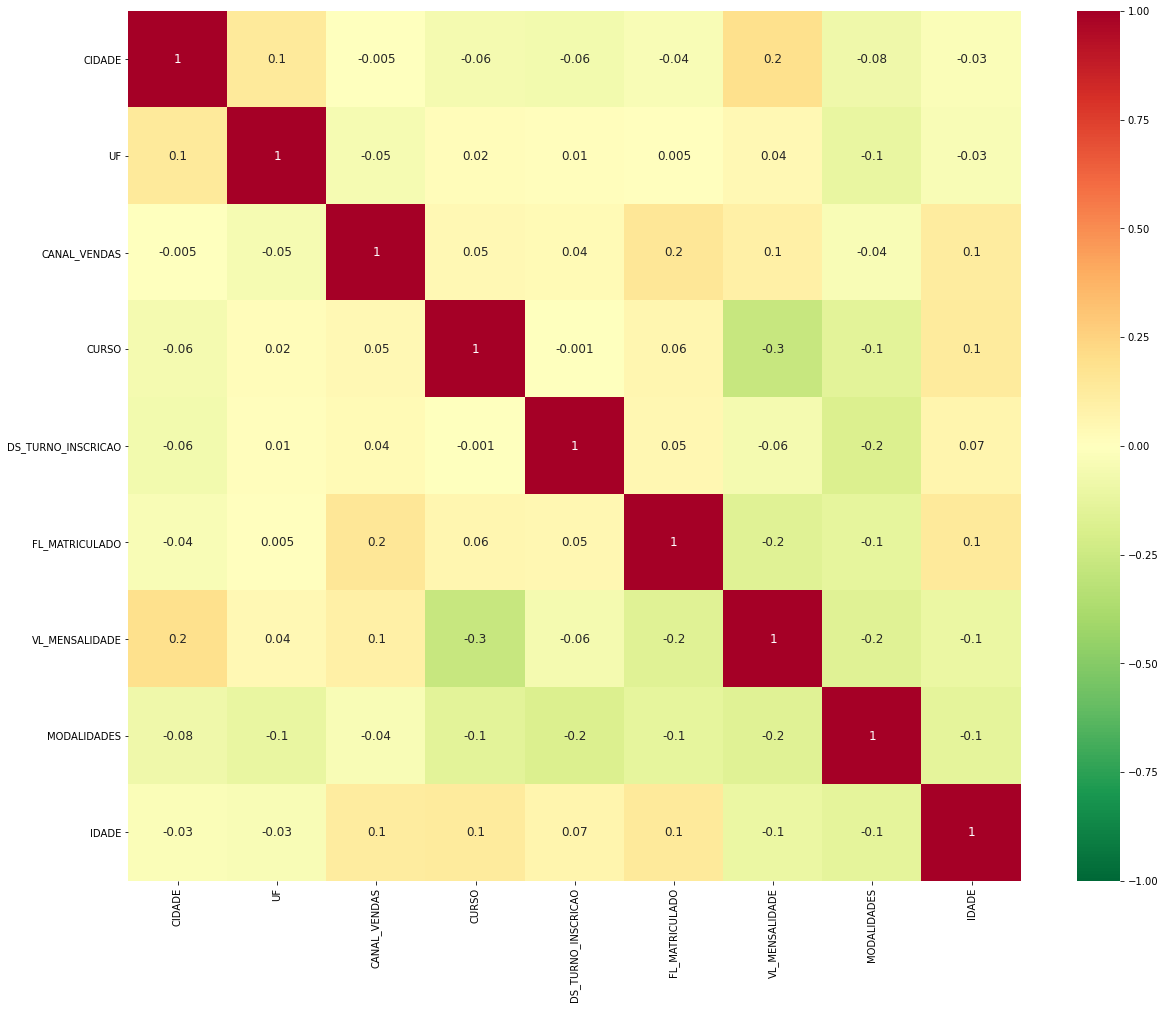

In [ ]:
# Matriz de correlação das variáveis numéricas
corrmat = df.corr()
ax = plt.subplots(figsize=(20, 16))
sns.heatmap(corrmat, annot=True, annot_kws={"size": 12}, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'RdYlGn_r');

In [ ]:
# Gráficos de dispersão das variáveis
import plotly.express as px
fig = px.scatter_matrix(df,width=1600, height=3600)
fig.show()

In [ ]:
# Dimensões após pre-processamento
df.shape

(1000, 9)

In [ ]:
# Visualizar primeiras e últimas linhas do DataFrame
df
# Salvando em Arquivo XLSX
#df.to_excel('df_numerico.xlsx', index=False)

CIDADE  UF  CANAL_VENDAS  CURSO  DS_TURNO_INSCRICAO  FL_MATRICULADO  \
0       183  26             7      0                   1               0   
1        61   8             7      0                   1               0   
2       286   0             7      0                   1               0   
3       272  23             0      0                   1               0   
4       163  26             0      0                   1               0   
..      ...  ..           ...    ...                 ...             ...   
995     251  18            12      0                   1               0   
996     350  26            12      0                   1               0   
997     361  26            12      0                   1               0   
998     134  27            12      0                   1               0   
999     359  26            12      0                   1               0   

     VL_MENSALIDADE  MODALIDADES      IDADE  
0              65.0            3  19.885355  
1              65.0            3  19.329560  
2              65.0            3  19.737508  
3              65.0            3  25.369382  
4              65.0            3  20.276875  
..              ...          ...        ...  
995            65.0            3  38.971304  
996            65.0            0  27.236635  
997            65.0            3  23.107871  
998            65.0            0  23.474751  
999           110.0            0  22.965500  

[1000 rows x 9 columns]

In [ ]:
# algumas estatísticas sobre as variáveis
df.describe()

CIDADE           UF  CANAL_VENDAS        CURSO  \
count  1000.000000  1000.000000   1000.000000  1000.000000   
mean    229.247000    16.534000      9.155000    33.968000   
std     108.918075     7.467168      4.763787    27.101688   
min       0.000000     0.000000      0.000000     0.000000   
25%     139.000000    11.000000      6.000000     4.000000   
50%     282.000000    19.000000     12.000000    27.000000   
75%     308.250000    23.000000     12.000000    59.000000   
max     386.000000    27.000000     20.000000    83.000000   

       DS_TURNO_INSCRICAO  FL_MATRICULADO  VL_MENSALIDADE  MODALIDADES  \
count         1000.000000      1000.00000     1000.000000  1000.000000   
mean             0.885000         0.04600       83.648040     1.740000   
std              0.328455         0.20959       22.953783     1.194079   
min              0.000000         0.00000        0.000000     0.000000   
25%              1.000000         0.00000       65.000000     1.000000   
50%              1.000000         0.00000       65.000000     2.000000   
75%              1.000000         0.00000      110.000000     3.000000   
max              2.000000         1.00000      110.000000     3.000000   

             IDADE  
count  1000.000000  
mean     26.847730  
std       8.566237  
min      17.623843  
25%      21.020217  
50%      23.853951  
75%      30.517332  
max     120.218695

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CIDADE              1000 non-null   int32  
 1   UF                  1000 non-null   int32  
 2   CANAL_VENDAS        1000 non-null   int32  
 3   CURSO               1000 non-null   int32  
 4   DS_TURNO_INSCRICAO  1000 non-null   int32  
 5   FL_MATRICULADO      1000 non-null   int64  
 6   VL_MENSALIDADE      1000 non-null   float64
 7   MODALIDADES         1000 non-null   int32  
 8   IDADE               1000 non-null   float64
dtypes: float64(2), int32(6), int64(1)
memory usage: 47.0 KB


In [ ]:
df['VL_MENSALIDADE'].value_counts()

65.00     572
110.00    421
0.00        5
73.75       1
84.29       1
Name: VL_MENSALIDADE, dtype: int64

In [ ]:
df.keys()

Index(['CIDADE', 'UF', 'CANAL_VENDAS', 'CURSO', 'DS_TURNO_INSCRICAO',
       'FL_MATRICULADO', 'VL_MENSALIDADE', 'MODALIDADES', 'IDADE'],
      dtype='object')

In [ ]:
df['CIDADE'] = pd.to_numeric(df['CIDADE']) 
df['UF'] = pd.to_numeric(df['UF']) 
df['CANAL_VENDAS'] = pd.to_numeric(df['CANAL_VENDAS']) 
df['CURSO'] = pd.to_numeric(df['CURSO']) 
df['DS_TURNO_INSCRICAO'] = pd.to_numeric(df['DS_TURNO_INSCRICAO']) 
df['FL_MATRICULADO'] = pd.to_numeric(df['FL_MATRICULADO']) 
df['VL_MENSALIDADE'] = pd.to_numeric(df['VL_MENSALIDADE']) 
df['MODALIDADES'] = pd.to_numeric(df['MODALIDADES']) 
df['IDADE'] = pd.to_numeric(df['IDADE'])

In [ ]:
df['FL_MATRICULADO'] = pd.get_dummies(df['FL_MATRICULADO'])

In [ ]:
df['FL_MATRICULADO'].value_counts()

1    954
0     46
Name: FL_MATRICULADO, dtype: int64

In [ ]:
df

CIDADE  UF  CANAL_VENDAS  CURSO  DS_TURNO_INSCRICAO  FL_MATRICULADO  \
0       183  26             7      0                   1               1   
1        61   8             7      0                   1               1   
2       286   0             7      0                   1               1   
3       272  23             0      0                   1               1   
4       163  26             0      0                   1               1   
..      ...  ..           ...    ...                 ...             ...   
995     251  18            12      0                   1               1   
996     350  26            12      0                   1               1   
997     361  26            12      0                   1               1   
998     134  27            12      0                   1               1   
999     359  26            12      0                   1               1   

     VL_MENSALIDADE  MODALIDADES      IDADE  
0              65.0            3  19.885355  
1              65.0            3  19.329560  
2              65.0            3  19.737508  
3              65.0            3  25.369382  
4              65.0            3  20.276875  
..              ...          ...        ...  
995            65.0            3  38.971304  
996            65.0            0  27.236635  
997            65.0            3  23.107871  
998            65.0            0  23.474751  
999           110.0            0  22.965500  

[1000 rows x 9 columns]

### Testando algoritmos de Clusterização

In [ ]:
# Testar os Algoritmos de Clusterização
# Utilizando a Biblioteca de AutoML PyCaret
# experimentação
# ignore features = variáveis redundantes 
# Auto Machine Learning
from pycaret.clustering import *
exp_clu101 = setup(data=df, normalize = True,
                   pca = True, pca_components = 5,
                   session_id = 42)

In [ ]:
# Criando modelo K-médias no PyCaret
kmeans = create_model('kmeans')

Silhouette  Calinski-Harabasz  Davies-Bouldin  Homogeneity  Rand Index  \
0      0.4562          2773.7128          0.7883            0           0   

   Completeness  
0             0

In [ ]:
# Visualizar parâmetros do Modelo
print(kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=42, tol=0.0001, verbose=0)


In [ ]:
# Plotar os Cluters calculados pelo PyCaret (Quantidade de Clusters = 4)
plot_model(kmeans)

In [ ]:
# Visualizar os Clusters no dataFrame
kmean_results = assign_model(kmeans)
kmean_results.head()

CIDADE  UF  CANAL_VENDAS  CURSO  DS_TURNO_INSCRICAO  FL_MATRICULADO  \
0     183  26             7      0                   1               1   
1      61   8             7      0                   1               1   
2     286   0             7      0                   1               1   
3     272  23             0      0                   1               1   
4     163  26             0      0                   1               1   

   VL_MENSALIDADE  MODALIDADES      IDADE    Cluster  
0            65.0            3  19.885355  Cluster 3  
1            65.0            3  19.329560  Cluster 0  
2            65.0            3  19.737508  Cluster 2  
3            65.0            3  25.369382  Cluster 2  
4            65.0            3  20.276875  Cluster 3

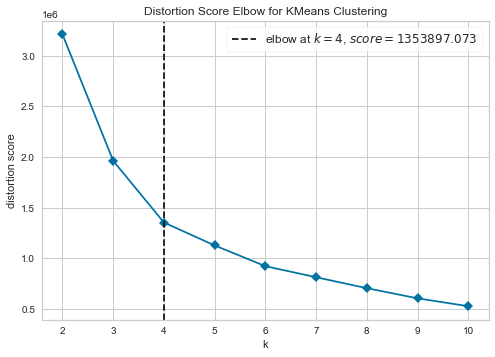

In [ ]:
# Plotar o método do Elbow para avaliar o número de Clusters k 
plot_model(kmeans, plot = 'elbow')

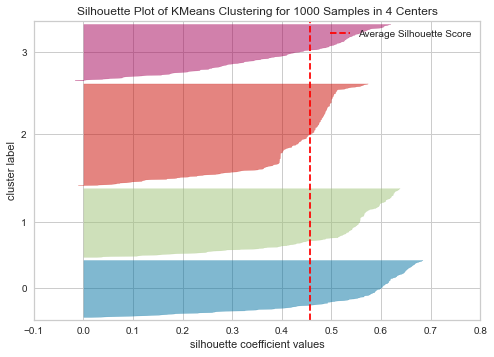

In [ ]:
# Plotar o método silhouette para avaliar o número de clusters
plot_model(kmeans, plot = 'silhouette')

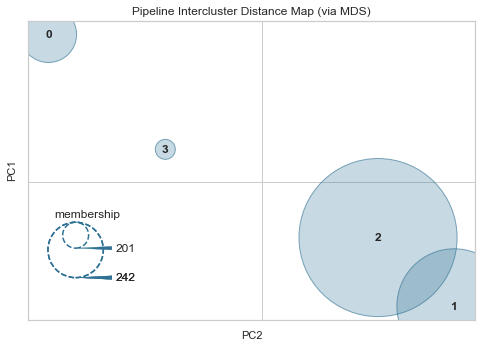

In [ ]:
# Visualisar distância entre os clusters
plot_model(kmeans, plot='distance')

In [ ]:
#Visualizar quantidade de Observações por Clusters
plot_model(kmeans, plot = 'distribution')

In [ ]:
#Visualisar distribuição do cidade nos Clusters
plot_model(kmeans, plot = 'distribution', feature = 'CIDADE')

In [ ]:
#Visualisar distribuição do CURSO nos Clusters
plot_model(kmeans, plot = 'distribution', feature = 'UF')

In [ ]:
#Visualisar distribuição do CURSO nos Clusters
plot_model(kmeans, plot = 'distribution', feature = 'CANAL_VENDAS')

In [ ]:
#Visualisar distribuição do CURSO nos Clusters
plot_model(kmeans, plot = 'distribution', feature = 'DS_TURNO_INSCRICAO')

In [ ]:
#Visualisar distribuição do CURSO nos Clusters
plot_model(kmeans, plot = 'distribution', feature = 'MODALIDADES')

In [ ]:
#Visualisar distribuição do CURSO nos Clusters
plot_model(kmeans, plot = 'distribution', feature = 'VL_MENSALIDADE')

In [ ]:
#Visualisar distribuição do IDADE nos Clusters
plot_model(kmeans, plot = 'distribution', feature = 'IDADE')

In [ ]:
#Visualisar distribuição do IDADE nos Clusters
plot_model(kmeans, plot = 'distribution', feature = 'FL_MATRICULADO')

No gráfico de ditribuição de FL_MATRICULADO foi observado que os clusters com maior numero de candidatos matriculados são os clusters 2 e 3, estes serão avaliados nas distribuições das outras variáveis, podendo inferir quais as variáveis tem maior numero de candidatados nos clusters 2 e 3, definindo assim o perfil das pessoas que tem maior chance de matricular-se


## DESAFIO

### PERFIL DAS PESSOAS COM MAIS CHANCE DE MATRICULAR-SE

- **IDADE**: 20 a 22 anos


- **CURSO:**
ADMINISTRAÇÃO
AGRONOMIA
ARQUITETURA
ARTES VISUAIS - LICENCIATURA
BIOMEDICINA
Direito - N
EDUCAÇÃO FÍSICA - BACHARELADO
EDUCAÇÃO FÍSICA - LICENCIATURA
ENFERMAGEM
ENGENHARIA CIVIL


- **CIDADE:**RIO DE JANEIRO


- **UF:** RJ


- **CANAL DE VENDAS:** CALL CENTER E INTERNET


- **DS_TURNO:** NOTURNO


- **MODALIDADES:** SEMI PRESENCIAL


- **VL_MENSALIDADE:** 65 e 110

### PESSOAS MAIS PROPENSAS A MATRICULAR-SE

Sugundo o perfil de pessoas com mais chance de matricular-se foi possível determinar quais as pessoas do banco de dados que tem essas caracteristicas e portanto são mais propensas a matricular-se, são elas (id_aluno): 

- 95
- 201
- 234
- 376
- 441
- 449
- 963
- 717
- 431
- 934

In [ ]:
# Padronização dos dados (Necessária, pois o K-means é baseado em distância euclidiana)
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(df)

In [ ]:
# Transformar array padronizado em Dataframe novamente
scaled_df = pd.DataFrame(scaled_df)
scaled_df.columns = df.columns
scaled_df

CIDADE        UF  CANAL_VENDAS     CURSO  DS_TURNO_INSCRICAO  \
0   -0.424816  1.268317     -0.452598 -1.253981            0.350299   
1   -1.545484 -1.143442     -0.452598 -1.253981            0.350299   
2    0.521322 -2.215334     -0.452598 -1.253981            0.350299   
3    0.392721  0.866357     -1.922752 -1.253981            0.350299   
4   -0.608532  1.268317     -1.922752 -1.253981            0.350299   
..        ...       ...           ...       ...                 ...   
995  0.199819  0.196424      0.597513 -1.253981            0.350299   
996  1.109214  1.268317      0.597513 -1.253981            0.350299   
997  1.210258  1.268317      0.597513 -1.253981            0.350299   
998 -0.874921  1.402304      0.597513 -1.253981            0.350299   
999  1.191886  1.268317      0.597513 -1.253981            0.350299   

     FL_MATRICULADO  VL_MENSALIDADE  MODALIDADES     IDADE  
0          0.219586       -0.812823     1.055734 -0.813176  
1          0.219586       -0.812823     1.055734 -0.878091  
2          0.219586       -0.812823     1.055734 -0.830444  
3          0.219586       -0.812823     1.055734 -0.172665  
4          0.219586       -0.812823     1.055734 -0.767448  
..              ...             ...          ...       ...  
995        0.219586       -0.812823     1.055734  1.415982  
996        0.219586       -0.812823    -1.457919  0.045422  
997        0.219586       -0.812823     1.055734 -0.436800  
998        0.219586       -0.812823    -1.457919 -0.393950  
999        0.219586        1.148619    -1.457919 -0.453428  

[1000 rows x 9 columns]

### Analise de componentes Principais (PCA)
- A análise de PCA foi aplicada visando reduzir o conjunto de dados, ou seja, excluindo variáveis desnecessárias. Essa estratégia é útil em situações onde o modelo é colocado em produção.

In [ ]:
# Ajustando o PCA para determinar quando PC são necessários para o nosso dado
pca = PCA()
pca = pca.fit(scaled_df)

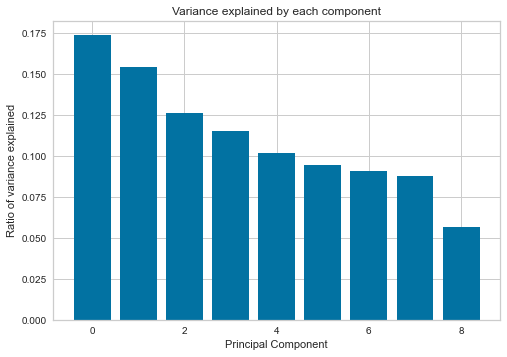

In [ ]:
# Investigar a variancia capturada por cada componente principal
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal Component")
plt.ylabel("Ratio of variance explained")
plt.show()

In [ ]:
#Porcentagem de variância explicada pelos 7 componentes do PCA
sum(pca.explained_variance_ratio_[0:6]*100)
# 7 componentes capturam aproximadamente 77% de variancia

76.49991232502698

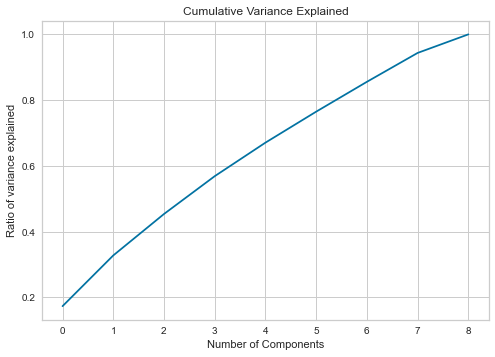

In [ ]:
# Visualizar a Variância acumulada explicada por cada PC
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()

In [ ]:
# Ajustar o PCA usando 6 componentes aos nossos dados 
pca_7 = PCA(n_components=6)
pca_fit = pca_7.fit(scaled_df)
escola_pca = pca_7.fit_transform(scaled_df)

In [ ]:
# Função
# Mapeaia os pesos de cada variável para cada componente (PC)
# imprime os resultados organizados pelo peso
def pca_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(scaled_df.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights

In [ ]:
# Pesos das Variáveis para a Component # 1 
pca_weight_0 = pca_weights(pca_7, 0)
print(pca_weight_0)

CURSO                 0.452866
IDADE                 0.441564
DS_TURNO_INSCRICAO    0.252833
CANAL_VENDAS          0.214620
UF                   -0.059694
CIDADE               -0.246171
MODALIDADES          -0.251171
VL_MENSALIDADE       -0.423397
FL_MATRICULADO       -0.428290
Name: 0, dtype: float64


In [ ]:
# Pesos das Variáveis para a Component # 2 
pca_weight_1 = pca_weights(pca_7, 1)
print(pca_weight_1)

MODALIDADES           0.576329
FL_MATRICULADO        0.121788
CURSO                 0.068295
IDADE                -0.141886
DS_TURNO_INSCRICAO   -0.204809
CANAL_VENDAS         -0.231455
UF                   -0.338217
CIDADE               -0.433728
VL_MENSALIDADE       -0.479779
Name: 1, dtype: float64


In [ ]:
# Pesos das Variáveis para a Component # 3
pca_weight_2 = pca_weights(pca_7, 2)
print(pca_weight_2)

CANAL_VENDAS          0.601028
VL_MENSALIDADE        0.301116
MODALIDADES           0.152611
IDADE                 0.147902
DS_TURNO_INSCRICAO   -0.011270
FL_MATRICULADO       -0.164791
CIDADE               -0.169381
CURSO                -0.377265
UF                   -0.551931
Name: 2, dtype: float64


In [ ]:
# Pesos das Variáveis para a Component # 4
pca_weight_3 = pca_weights(pca_7, 3)
print(pca_weight_3)

CIDADE                0.380304
CANAL_VENDAS          0.268132
CURSO                 0.267803
MODALIDADES           0.197932
UF                    0.130926
IDADE                 0.129440
VL_MENSALIDADE       -0.051263
FL_MATRICULADO       -0.206072
DS_TURNO_INSCRICAO   -0.770447
Name: 3, dtype: float64


In [ ]:
# Pesos das Variáveis para a Component # 5
pca_weight_4 = pca_weights(pca_7, 4)
print(pca_weight_4)

UF                    0.404140
MODALIDADES           0.222133
DS_TURNO_INSCRICAO    0.110859
CANAL_VENDAS          0.022648
CIDADE               -0.027550
VL_MENSALIDADE       -0.195160
IDADE                -0.302248
CURSO                -0.436171
FL_MATRICULADO       -0.673854
Name: 4, dtype: float64


In [ ]:
# Pesos das Variáveis para a Component # 6
pca_weight_5 = pca_weights(pca_7, 5)
print(pca_weight_5)

IDADE                 0.621557
CIDADE                0.328722
MODALIDADES           0.049521
DS_TURNO_INSCRICAO   -0.029994
VL_MENSALIDADE       -0.098067
FL_MATRICULADO       -0.145044
UF                   -0.220269
CURSO                -0.396773
CANAL_VENDAS         -0.515417
Name: 5, dtype: float64


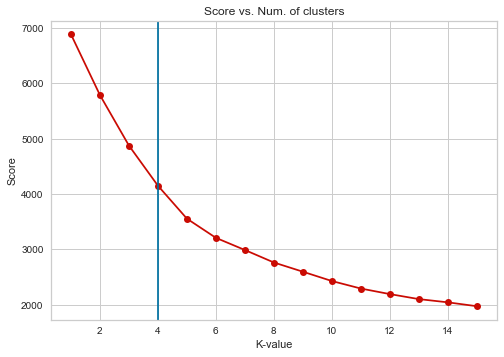

In [ ]:
#escolher o número de clusters pelo método do Elbow
def get_kmeans_score(data, center):
    # Inicializa o modelo
    kmeans = KMeans(n_clusters=center)
    # Ajusta o modelo aos dados
    model = kmeans.fit(data)
    # Pega o score do ajuste do modelo para cada 
    score = np.abs(model.score(data))
    return score

scores = []
centers = list(range(1,16))

# looping thru all the centers
for center in centers:
    scores.append(get_kmeans_score(escola_pca, center))
# Plotando Score vs. Number of clusters
plt.plot(centers, scores, linestyle='-', marker='o', color='r');
plt.axvline(x=4);
plt.xlabel('K-value');
plt.ylabel('Score');
plt.title('Score vs. Num. of clusters');

In [ ]:
# Visualizar os scores relacionados ao Valor de K
scores

[6884.992109252426,
 5787.6253408237335,
 4875.716034862119,
 4151.167575153156,
 3555.918165302182,
 3209.575220968293,
 2989.9411203675436,
 2764.289772213946,
 2597.9105002011133,
 2429.5894302069005,
 2293.8774458103026,
 2193.5482699369695,
 2103.053764291869,
 2044.6321627866487,
 1974.6454851418314]

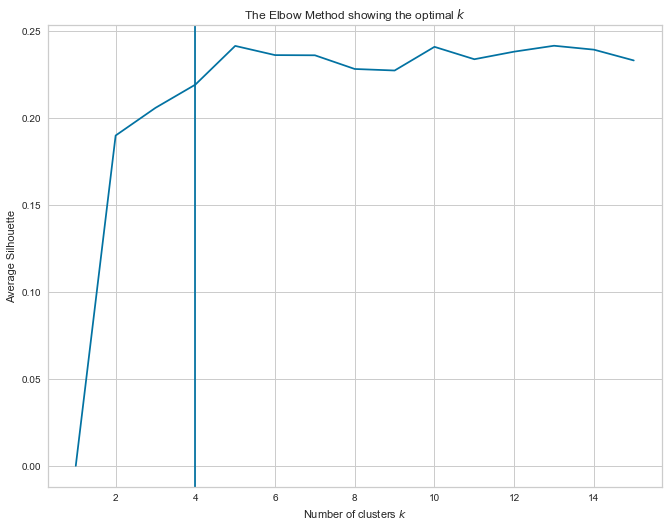

In [ ]:
# Visualizar o indice silhouette para cada K
scores = [0]
for i in range(2,16):
    fitx = KMeans(n_clusters=i, random_state=42).fit(escola_pca)
    score = silhouette_score(escola_pca, fitx.labels_)
    scores.append(score)
    
plt.figure(figsize=(11,8.5))
plt.plot(range(1,16), np.array(scores), 'bx-')
plt.axvline(x=4);
plt.xlabel('Number of clusters $k$')
plt.ylabel('Average Silhouette')
plt.title('The Elbow Method showing the optimal $k$')
plt.show()

In [ ]:
# Visualizar os scores relacionados ao Valor de K
scores

[0,
 0.1900155355229262,
 0.20593976262110708,
 0.21929863142572303,
 0.2415807981460519,
 0.23628707038279484,
 0.236178316264828,
 0.22829764967254862,
 0.22742742116490125,
 0.2410408336997349,
 0.2339088397744241,
 0.2382716664678012,
 0.24167100174712525,
 0.23941966587955607,
 0.2332132248911295]

In [ ]:
# Gráfico de Silhouette para cada Cluster
def silplot(X, clusterer, pointlabels=None):
    cluster_labels = clusterer.labels_
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16,10)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 20])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 20
    for i in range(0,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 15  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    xs = X[:, 0]
    ys = X[:, 1]
    
    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

In [ ]:
# Ajuste do Kmeans com 4 clusters
fitted_km = KMeans(n_clusters=4, random_state=42).fit(escola_pca)

For n_clusters = 4, the average silhouette_score is 0.21929863142572303.


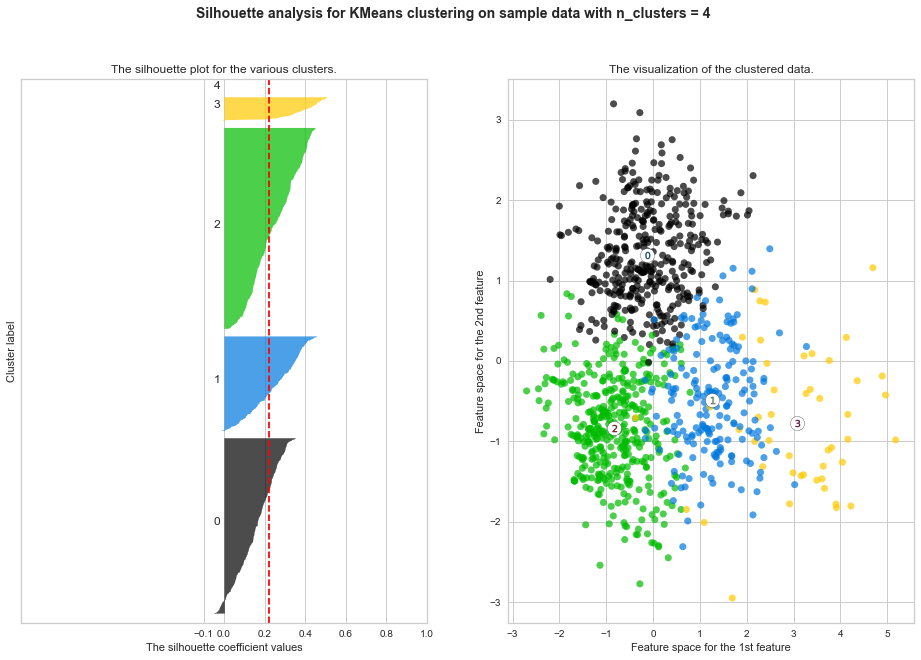

In [ ]:
# Análise de Silhouette para k = 4 Clusters
silplot(escola_pca, fitted_km)

In [ ]:
# Calcular os clusters para o nosso dataframe
cluster_pred = fitted_km.predict(escola_pca)

In [ ]:
cluster_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2,
       0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2,
       0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 3, 2, 3, 2, 2, 2, 0, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 0, 0, 2, 0,
       2, 0, 0, 0, 0, 0, 2, 0, 3, 1, 3, 0, 0, 3, 2, 0, 2, 0, 0, 2, 0, 2,
       2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2,

<AxesSubplot:ylabel='count'>

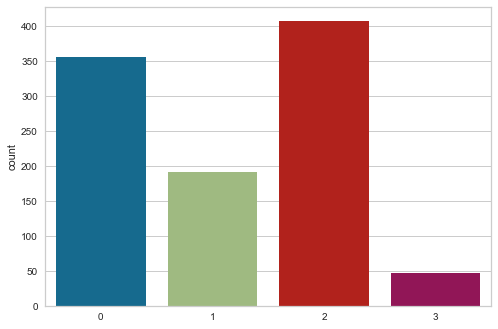

In [ ]:
# Visualizar a quantidade de 'unidades' por Clusters
sns.countplot(cluster_pred)

In [ ]:
# Contar a quantidade de municípios por Clusters
Counter(cluster_pred)

Counter({0: 355, 2: 407, 3: 47, 1: 191})

In [ ]:
cust_df = pd.DataFrame(cluster_pred, columns=['Cluster']).reset_index().groupby('Cluster').count() / len(cluster_pred)*100

In [ ]:
# Porcentagem de unidades por Cluster
display(cust_df)

index
Cluster       
0         35.5
1         19.1
2         40.7
3          4.7

In [ ]:
# Adicionar os clusters ao DataFrame Inicial 
df['cluster'] = cluster_pred

In [ ]:
# Salvando o resultado dos Clusters em um Arquivo CSV 
df.to_csv('saida_clusters.csv', index=False, sep="," , encoding="UTF8")

In [ ]:
#lendo o arquio salvo (visualização)
df_salvo = pd.read_csv('saida_clusters.csv')

In [ ]:
df_salvo.head()

CIDADE  UF  CANAL_VENDAS  CURSO  DS_TURNO_INSCRICAO  FL_MATRICULADO  \
0     183  26             7      0                   1               1   
1      61   8             7      0                   1               1   
2     286   0             7      0                   1               1   
3     272  23             0      0                   1               1   
4     163  26             0      0                   1               1   

   VL_MENSALIDADE  MODALIDADES      IDADE  cluster  
0            65.0            3  19.885355        0  
1            65.0            3  19.329560        0  
2            65.0            3  19.737508        0  
3            65.0            3  25.369382        0  
4            65.0            3  20.276875        0

## Modelo de Classificação para  predições de demais alunos a partir de um modelo pré-treinado


- Aqui foi gerado um modelo de classificação para utilização na predição de alunos novos. O modelo foi treinado com os dados cedidos e as classes são os clusters obtidos pelo k-means. Portanto, a partir de dados de um aluno novo, é possível inferir se ele se adequa ao perfil de pessoas que podem se matricular.

In [ ]:
# Testar diferentes modelos de Classificação usando o PyCaret

from pycaret.classification import *
clf1 = setup(data = df, target = 'cluster', session_id = 42, silent = True)

In [ ]:
# Checando Modelos existentes no PyCaret
models()

Name  \
ID                                          
lr                    Logistic Regression   
knn                K Neighbors Classifier   
nb                            Naive Bayes   
dt               Decision Tree Classifier   
svm                   SVM - Linear Kernel   
rbfsvm                SVM - Radial Kernel   
gpc           Gaussian Process Classifier   
mlp                        MLP Classifier   
ridge                    Ridge Classifier   
rf               Random Forest Classifier   
qda       Quadratic Discriminant Analysis   
ada                  Ada Boost Classifier   
gbc          Gradient Boosting Classifier   
lda          Linear Discriminant Analysis   
et                 Extra Trees Classifier   
lightgbm  Light Gradient Boosting Machine   
catboost              CatBoost Classifier   

                                                  Reference  Turbo  
ID                                                                  
lr        sklearn.linear_model._logistic.LogisticRegression   True  
knn       sklearn.neighbors._classification.KNeighborsCl...   True  
nb                           sklearn.naive_bayes.GaussianNB   True  
dt             sklearn.tree._classes.DecisionTreeClassifier   True  
svm       sklearn.linear_model._stochastic_gradient.SGDC...   True  
rbfsvm                             sklearn.svm._classes.SVC  False  
gpc       sklearn.gaussian_process._gpc.GaussianProcessC...  False  
mlp       sklearn.neural_network._multilayer_perceptron....  False  
ridge           sklearn.linear_model._ridge.RidgeClassifier   True  
rf          sklearn.ensemble._forest.RandomForestClassifier   True  
qda       sklearn.discriminant_analysis.QuadraticDiscrim...   True  
ada       sklearn.ensemble._weight_boosting.AdaBoostClas...   True  
gbc         sklearn.ensemble._gb.GradientBoostingClassifier   True  
lda       sklearn.discriminant_analysis.LinearDiscrimina...   True  
et            sklearn.ensemble._forest.ExtraTreesClassifier   True  
lightgbm                    lightgbm.sklearn.LGBMClassifier   True  
catboost                   catboost.core.CatBoostClassifier   True

In [ ]:
#Testando os modelos de Classificação -  10 K-folds
best_model = compare_models(exclude = ['qda', 'lr'])

In [ ]:
# O Modelo que obteve o melhor desempenho nos nossos dados foi o Modelo catboost (Gradient boosting on decision trees).
# Criando uma instância do modelo utilizando o PyCaret
catboost = create_model('catboost')

In [ ]:
# Escolher os melhores parâmetros para o modelo de Classificação
tuned_catboost = tune_model(catboost)

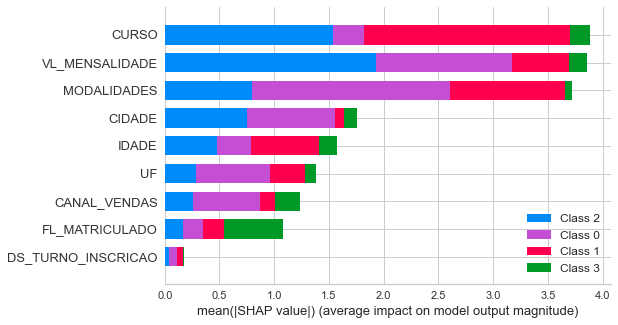

In [ ]:
# Verificar a impotância de cada variável na classificação do modelo
interpret_model(tuned_catboost)

In [ ]:
# Checar os parâmetros Calibrados
print(tuned_catboost.get_params())

{'depth': 2, 'l2_leaf_reg': 4, 'border_count': 254, 'verbose': False, 'random_strength': 0.0, 'task_type': 'CPU', 'n_estimators': 130, 'random_state': 42, 'eta': 0.5}


In [ ]:
# Separar as variáveis das classes alvo de classificação 
X = df.drop("cluster", axis=1)
y = df["cluster"]

In [ ]:
# Separar o nosso DataFrame em Treinamento e Validação
# 80% para trinamento
# 20% validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Instanciar o modelo  CatBoost com os parâmetros ótimos encontrados pela otimização do PyCaret
clf = CatBoostClassifier(
    iterations=500, 
    learning_rate=0.2,
    depth = 2,
    l2_leaf_reg = 4,
    custom_loss=['AUC', 'Accuracy'])

In [ ]:
# Ajustando o modelo aos nossos dados
clf.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
# Visualizar a importância de cada variável para a classificação do modelo
clf.get_feature_importance(prettified=True)

Feature Id  Importances
0         MODALIDADES    27.863141
1               CURSO    19.410991
2      VL_MENSALIDADE    18.646306
3      FL_MATRICULADO     9.465002
4              CIDADE     8.274526
5               IDADE     6.731695
6                  UF     4.817471
7        CANAL_VENDAS     4.278533
8  DS_TURNO_INSCRICAO     0.512336

In [ ]:
# Salvando a Importânia de classes num dataFrame
feature_importance_df = pd.DataFrame(clf.get_feature_importance(prettified=True))

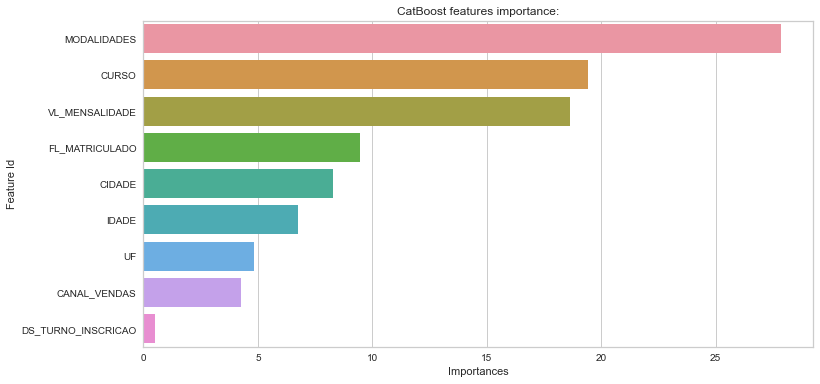

In [ ]:
# Plotando a Importância das variáveis
plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=feature_importance_df);
plt.title('CatBoost features importance:');

In [ ]:
# Separando os dados de validação do modelo
predicted_y = clf.predict(data=X_val)
expected_y = y_val

In [ ]:
# Avaliando as métricas do modelo calibrado
print('CatBoost: ')
print(classification_report(expected_y, predicted_y, target_names=['0','1','2','3']))
print(confusion_matrix(expected_y, predicted_y))

CatBoost: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        61
           1       0.98      0.98      0.98        47
           2       0.98      0.98      0.98        83
           3       1.00      1.00      1.00         9

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200

[[60  0  1  0]
 [ 0 46  1  0]
 [ 1  1 81  0]
 [ 0  0  0  9]]


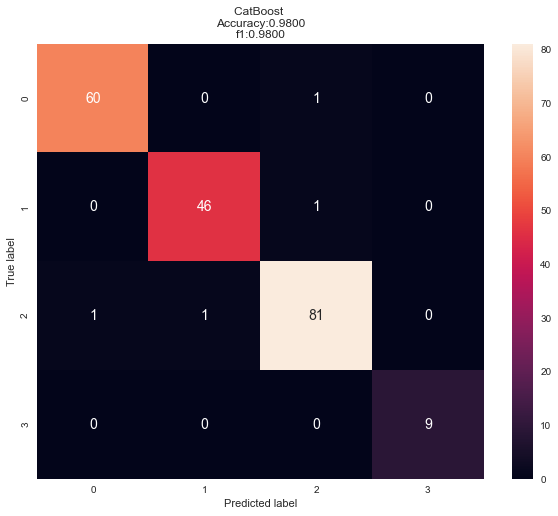

In [ ]:
# Avaliação do modelo ajustado nos nossos dados
# Utilizando os dados de validação para avaliar

# Criando a matriz de confusão
cm = confusion_matrix(expected_y, predicted_y) 

# Transformando em dataframe para facilitar a plotagem
cm_df = pd.DataFrame(cm)

#Plotando a análise de ajuste do modelo nos nossos dados de validação
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='.0f', annot_kws={"size": 14})
recall = recall_score(expected_y, predicted_y, average='micro')
precision = precision_score(expected_y, predicted_y, average='micro')
f1 = f1_score(expected_y, predicted_y, average='micro')
accuracy = accuracy_score(expected_y, predicted_y)
plt.title('CatBoost \nAccuracy:{0:.4f}\nf1:{0:.4f}'.format(accuracy, f1))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Separando a classificação e a probabilidade de ser cada classe
labels = clf.predict(data=X_val)
probabilidades = clf.predict_proba(data=X_val)

In [ ]:
# Transformando as probabilidades em DataFrame
probabilidades = pd.DataFrame(probabilidades, columns = ["Cluster 0", "Cluster 1","Cluster 2","Cluster 3"])

In [ ]:
# Adicionando  as labels das classes 
probabilidades['classificacao'] = labels

In [ ]:
probabilidades

Cluster 0  Cluster 1  Cluster 2  Cluster 3  classificacao
0     0.000439   0.002154   0.997076   0.000331              2
1     0.930516   0.068753   0.000002   0.000729              0
2     0.996459   0.002426   0.000624   0.000492              0
3     0.101827   0.840711   0.054513   0.002949              1
4     0.000007   0.000220   0.999693   0.000079              2
..         ...        ...        ...        ...            ...
195   0.000729   0.000278   0.998843   0.000150              2
196   0.000092   0.000053   0.999718   0.000136              2
197   0.000028   0.000003   0.999918   0.000051              2
198   0.002937   0.008200   0.988201   0.000662              2
199   0.000023   0.000002   0.999927   0.000048              2

[200 rows x 5 columns]

In [ ]:
# Adicionando as classes e probabilidades para todo o dataset
df_clean = df.drop("cluster", axis=1)
labels = clf.predict(data=df_clean)
probabilidades = clf.predict_proba(data=df_clean)
probabilidades = pd.DataFrame(probabilidades, columns = ["Prob_Cluster_0", "Prob_Cluster_1","Prob_Cluster_2","Prob_Cluster_3"])

In [ ]:
# Adicionando os clusters no dataset
df_clean['cluster'] = labels

In [ ]:
# Concatenando a matriz de probabilidade ao DataFrame
concat = pd.concat([df_clean, probabilidades], axis= 1)

In [ ]:
concat

CIDADE  UF  CANAL_VENDAS  CURSO  DS_TURNO_INSCRICAO  FL_MATRICULADO  \
0       183  26             7      0                   1               1   
1        61   8             7      0                   1               1   
2       286   0             7      0                   1               1   
3       272  23             0      0                   1               1   
4       163  26             0      0                   1               1   
..      ...  ..           ...    ...                 ...             ...   
995     251  18            12      0                   1               1   
996     350  26            12      0                   1               1   
997     361  26            12      0                   1               1   
998     134  27            12      0                   1               1   
999     359  26            12      0                   1               1   

     VL_MENSALIDADE  MODALIDADES      IDADE  cluster  Prob_Cluster_0  \
0              65.0            3  19.885355        0    9.910179e-01   
1              65.0            3  19.329560        0    9.999662e-01   
2              65.0            3  19.737508        0    9.988653e-01   
3              65.0            3  25.369382        0    9.940157e-01   
4              65.0            3  20.276875        0    9.977238e-01   
..              ...          ...        ...      ...             ...   
995            65.0            3  38.971304        0    9.449316e-01   
996            65.0            0  27.236635        2    9.284295e-05   
997            65.0            3  23.107871        2    3.891883e-01   
998            65.0            0  23.474751        2    2.417025e-02   
999           110.0            0  22.965500        2    1.775608e-07   

     Prob_Cluster_1  Prob_Cluster_2  Prob_Cluster_3  
0      9.484295e-05        0.008051        0.000836  
1      6.802595e-07        0.000022        0.000011  
2      6.181980e-06        0.001025        0.000103  
3      4.010425e-05        0.005552        0.000392  
4      3.717118e-05        0.002043        0.000196  
..              ...             ...             ...  
995    3.988747e-03        0.037577        0.013502  
996    4.109203e-03        0.994668        0.001130  
997    9.994537e-04        0.603227        0.006585  
998    5.771273e-02        0.910881        0.007236  
999    4.913148e-06        0.999984        0.000011  

[1000 rows x 14 columns]

In [ ]:
# Salvando em Arquivo CSV
concat.to_csv('final_concat.csv', index=False, sep="," , encoding="UTF8")

In [ ]:
# Salvando modelo calibrado CatBoost
with open('sale_catboost.pkl', 'wb') as file:
    pickle.dump(clf, file)